# pipeline-full-2s-segs-oa-ya

This notebook covers the pipeline for the neural noise analysis on full recordings, done on both older adults and younger adults. A matrix is constructed that contains the eyes open and eyes closed slopes for both groups.

1. Import all subjects
2. For each subject, extract all segments that are marked for analysis. 
3. For each segment extracted, extract as many 2-second segments with 50% overlap as we can.
4. Use these segments to compute the PSD through Welch's method.
5. Calculate the slope of each channel, and find the mean slope for each subject. 
6. Import the behavior table and add all slope results. Export to a CSV.

In [53]:
%matplotlib inline
import os
import glob
import seaborn as sns
import numpy as np
import scipy as sp
import pandas as pd
import scipy.io
import numpy.fft
import scipy.signal
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import linregress
from sklearn import linear_model
mpl.rcParams['figure.figsize'] = (16, 10)

Since we've done the PSD computation already, we just need to load the data and fit lines:

In [2]:
subjoa = np.load('../data/pipeline-full/subjoa-no-fitting.npy').item()
subjya = np.load('../data/pipeline-full/subjya-no-fitting.npy').item()

Let's fit the data using a 2 - 24 Hz range and regular linear regression.

In [3]:
def linreg_slope(f, psd, lofreq, hifreq):
    """
    Fits line to the PSD, using regular linear regression.
    Returns slope and fit line.
    """
    model = linear_model.LinearRegression()
    model.fit(f[2*2:24*2], np.log10(psd[2*2:24*2]))
    fit_line = model.predict(f)
    return model.coef_[0] * (10**2), fit_line

def fit_slopes(subj, regr_func, lofreq, hifreq):
    # Fitting on the grand average PSD of all subjects
    eyesC_slope_and_fitline = regr_func(subj['f'], subj['eyesC_psd'], lofreq, hifreq)
    eyesO_slope_and_fitline = regr_func(subj['f'], subj['eyesO_psd'], lofreq, hifreq)
    subj['eyesC_slope'], subj['eyesC_fitline'] = eyesC_slope_and_fitline
    subj['eyesO_slope'], subj['eyesO_fitline'] = eyesO_slope_and_fitline
    for i in range(subj['nbsubj']):
        # Per-subject PSD average fitting
        eyesC_slope_and_fitline = regr_func(subj['f'], subj[i]['eyesC_psd'], lofreq, hifreq)
        eyesO_slope_and_fitline = regr_func(subj['f'], subj[i]['eyesO_psd'], lofreq, hifreq)
        subj[i]['eyesC_slope'], subj[i]['eyesC_fitline'] = eyesC_slope_and_fitline
        subj[i]['eyesO_slope'], subj[i]['eyesO_fitline'] = eyesO_slope_and_fitline
        for ch in range(subj[i]['nbchan']):
            # Per-channel PSD fitting
            eyesC_slope_and_fitline = regr_func(subj['f'], subj[i][ch]['eyesC_psd_rm_alpha'], lofreq, hifreq)
            eyesO_slope_and_fitline = regr_func(subj['f'], subj[i][ch]['eyesO_psd_rm_alpha'], lofreq, hifreq)
            subj[i][ch]['eyesC_slope'], subj[i][ch]['eyesC_fitline'] = eyesC_slope_and_fitline
            subj[i][ch]['eyesO_slope'], subj[i][ch]['eyesO_fitline'] = eyesO_slope_and_fitline
    return subj

In [4]:
subjoa = fit_slopes(subjoa, linreg_slope, 2, 24)
subjya = fit_slopes(subjya, linreg_slope, 2, 24)

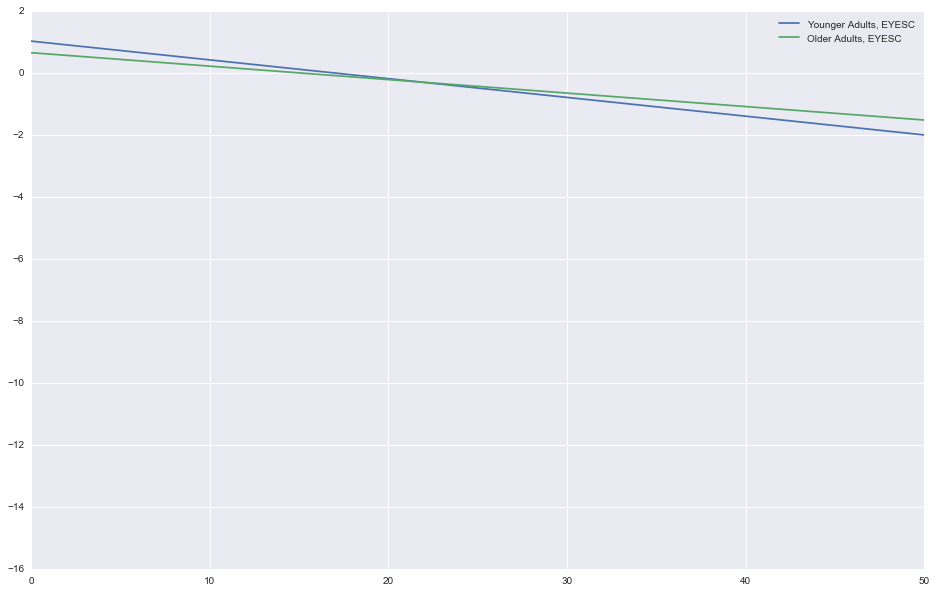

In [5]:
# Sanity check
plt.plot(subjya['f'], subjya['eyesC_fitline'], label='Younger Adults, EYESC')
plt.plot(subjoa['f'], subjoa['eyesC_fitline'], label='Older Adults, EYESC')
plt.xlim([0, 50]); plt.legend()

In [6]:
np.save('../data/pipeline-full/subjoa-2-24fit.npy', subjoa)
np.save('../data/pipeline-full/subjya-2-24fit.npy', subjya)

## load matrix and add slopes

In [7]:
# Another sanity check:
df = pd.read_csv('../data/ya-oa.csv')
df.SUBJECT = list(map(str, df.SUBJECT))
oa_names = [subjoa[i]['name'] for i in range(subjoa['nbsubj'])]
ya_names = [subjya[i]['name'] for i in range(subjya['nbsubj'])]
names = np.concatenate([oa_names, ya_names], axis=0)
print(set(names) == set(df.SUBJECT))
df[df.SUBJECT == names[0]]

True


,SUBJECT,CLASS,AGE,SEX
0,120127101,SA_Control,80.84873,2.0


In [8]:
channels = ["A1","A2","A3","A4","A5","A6","A7","A8","A10","A11","A12","A13","A14","A15","A16","A17","A18","A21","A22","A23","A24","A25","A26","A27","A29","A30","A31","B1","B2","B3","B4","B5","B6","B8","B9","B10","B11","B12","B13","B14","B17","B18","B19","B20","B21","B22","B23","B24","B26","B27","B28","B29","B30","FRONTAL","LTEMPORAL","CENTRAL","RTEMPORAL","OCCIPITAL"]

In [9]:
def get_subject_slopes(subj, ch, slope_type):
    if ch == -1: # Slope of PSD grand average
        return [subj[i][slope_type]     for i in range(subj['nbsubj'])]
    else:
        return [subj[i][ch][slope_type] for i in range(subj['nbsubj'])]

# Add the overall older adult and younger adult PSD slope.
df['AVG_OA_PSD_EYESC'] = subjoa['eyesC_slope']
df['AVG_OA_PSD_EYESO'] = subjoa['eyesO_slope']
df['AVG_YA_PSD_EYESC'] = subjya['eyesC_slope']
df['AVG_YA_PSD_EYESO'] = subjya['eyesO_slope']
    
# Add each subject's mean slope. This is found by finding the subject's average PSD and
# fitting a line to it.
oa_avg_psd_eyesc = get_subject_slopes(subjoa, -1, 'eyesC_slope')
oa_avg_psd_eyeso = get_subject_slopes(subjoa, -1, 'eyesO_slope')
ya_avg_psd_eyesc = get_subject_slopes(subjya, -1, 'eyesC_slope')
ya_avg_psd_eyeso = get_subject_slopes(subjya, -1, 'eyesO_slope')
df['AVG_PSD_EYESC'] = np.concatenate([oa_avg_psd_eyesc, ya_avg_psd_eyesc], axis=0)
df['AVG_PSD_EYESO'] = np.concatenate([oa_avg_psd_eyeso, ya_avg_psd_eyeso], axis=0)

# Now add slopes for every channel from each subject. 
for ch in range(len(channels)):
    
    oa_psd_eyesc = get_subject_slopes(subjoa, ch, 'eyesC_slope')
    ya_psd_eyesc = get_subject_slopes(subjya, ch, 'eyesC_slope')

    oa_psd_eyeso = get_subject_slopes(subjoa, ch, 'eyesO_slope')
    ya_psd_eyeso = get_subject_slopes(subjya, ch, 'eyesO_slope')
    
    df[channels[ch] + '_EYESC'] = np.concatenate([oa_psd_eyesc, ya_psd_eyesc], axis=0)
    df[channels[ch] + '_EYESO'] = np.concatenate([oa_psd_eyeso, ya_psd_eyeso], axis=0)

In [10]:
df.head()

,SUBJECT,CLASS,AGE,SEX,AVG_OA_PSD_EYESC,AVG_OA_PSD_EYESO,AVG_YA_PSD_EYESC,AVG_YA_PSD_EYESO,AVG_PSD_EYESC,AVG_PSD_EYESO,...,FRONTAL_EYESC,FRONTAL_EYESO,LTEMPORAL_EYESC,LTEMPORAL_EYESO,CENTRAL_EYESC,CENTRAL_EYESO,RTEMPORAL_EYESC,RTEMPORAL_EYESO,OCCIPITAL_EYESC,OCCIPITAL_EYESO
0,120127101,SA_Control,80.84873,2.0,-4.34227,-3.134892,-6.051054,-5.046973,-6.862338,-5.993324,...,-8.672824,-7.766009,-10.355797,-9.870920,-8.886973,-9.256354,-9.514349,-8.718649,-7.726645,-7.131687
1,120127102,MCI_Control,71.89870,1.0,-4.34227,-3.134892,-6.051054,-5.046973,-5.043768,-1.707319,...,-6.822904,-3.996478,-6.491346,-3.017757,-6.675483,-5.742492,-5.226341,-1.570847,-6.432560,-3.653080
2,120127103,MCI_Control,69.43463,2.0,-4.34227,-3.134892,-6.051054,-5.046973,-4.404398,-2.421660,...,-4.235969,-4.397806,-6.102922,-5.551192,-6.771141,-6.602679,-5.542418,-5.150955,-3.417101,-3.998930
3,120127104,SA_Control,83.61396,2.0,-4.34227,-3.134892,-6.051054,-5.046973,-4.147895,-2.305099,...,-6.391124,-4.478913,-6.255836,-5.451922,-5.435296,-4.705022,-5.914093,-4.571635,-6.477717,-5.189071
4,120127105,SA_Control,80.69541,2.0,-4.34227,-3.134892,-6.051054,-5.046973,-5.327249,-5.730176,...,-6.609690,-5.981445,-6.667336,-5.432904,-7.119155,-6.554409,-7.226378,-6.100613,-8.148066,-8.137746


In [11]:
df.to_csv('../data/pipeline-full/ya-oa-full-rec-slopes-2-24.csv', index=False)

## Statistical Analysis

Let's start with doing a few simple things. Let's first look at the PSDs of each group separately, and then run t-tests on all of the slopes to see if there are any significant differences.

In [33]:
subjoa = np.load('../data/pipeline-full/subjoa-2-24fit.npy').item()
subjya = np.load('../data/pipeline-full/subjya-2-24fit.npy').item()

In [34]:
older_adults = ['SA_Control', 'MCI_Control', 'MCI']
ya_psd = np.mean([subjya[i]['eyesC_psd'] for i in range(subjya['nbsubj'])], axis=0)
oa_psd = np.mean([subjoa[i]['eyesC_psd'] for i in range(subjoa['nbsubj']) if subjoa[i]['class'] in older_adults], axis=0)

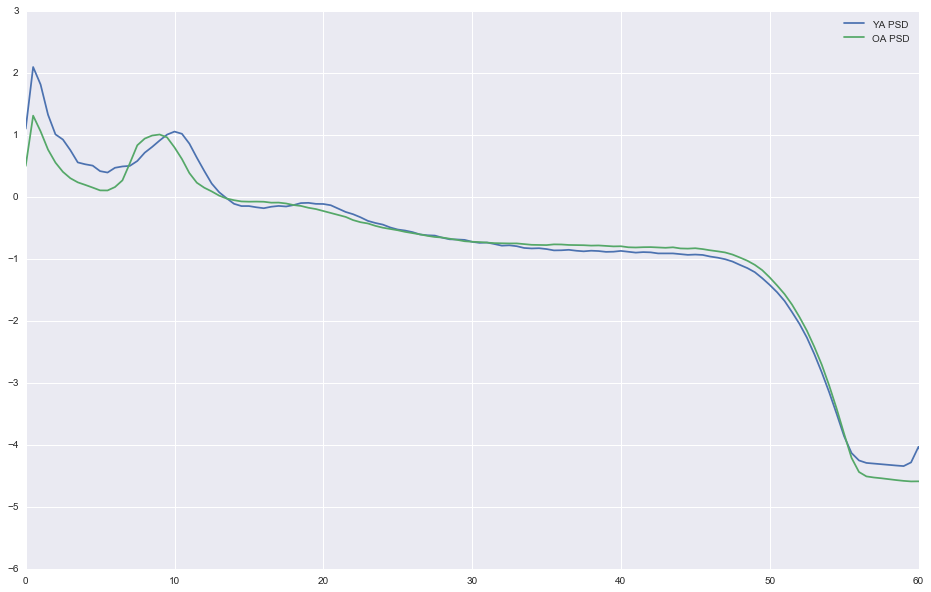

In [35]:
plt.plot(subjoa['f'], np.log10(ya_psd), label='YA PSD')
plt.plot(subjoa['f'], np.log10(oa_psd), label='OA PSD')
plt.xlim([0, 60]); plt.legend()

(-1, 1)

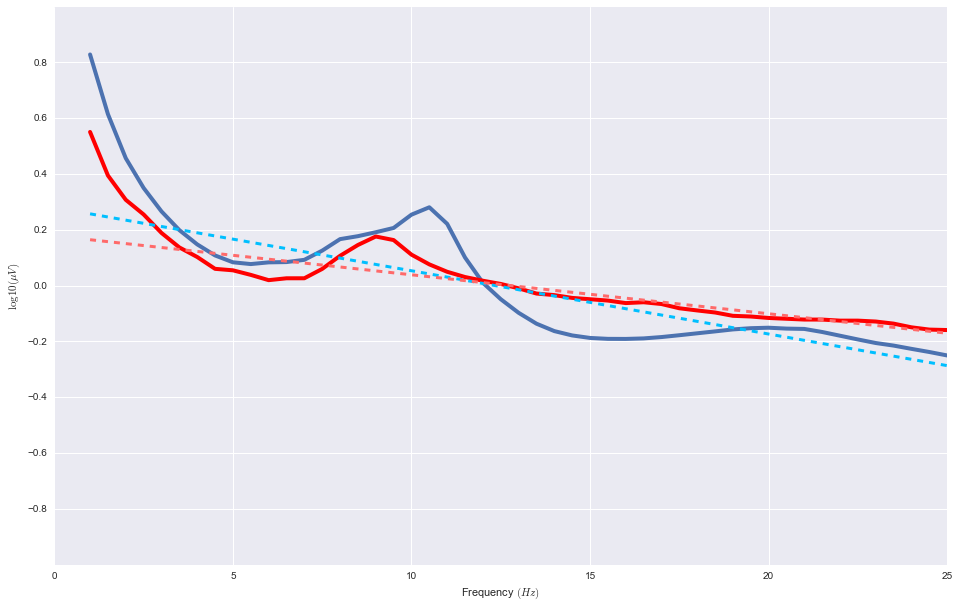

In [116]:
def remove_freq_buffer(data, lofreq, hifreq):
    """
    Removes a frequency buffer from a PSD or frequency vector.
    """
    data = np.delete(data, range(lofreq*2, hifreq*2))
    return data.reshape(len(data), 1)

def linreg_slope(f, psd, lofreq, hifreq):
    """
    Fits line to the PSD, using regular linear regression.
    Returns slope and fit line.
    """
    model = linear_model.LinearRegression()
    model.fit(f[2*2:24*2], np.log10(psd[2*2:24*2]))
    fit_line = model.predict(f)
    return model.coef_[0] * (10**2), fit_line

older_adults = ['MCI_Control', 'MCI']
# older_adults = ['SA_Control', 'MCI_Control', 'MCI']
ya_psd = np.mean([subjya[i]['eyesO_psd'] for i in range(subjya['nbsubj'])], axis=0)
oa_psd = np.mean([subjoa[i]['eyesO_psd'] for i in range(subjoa['nbsubj']) if subjoa[i]['class'] in older_adults], axis=0)

ya_psd = remove_freq_buffer(ya_psd, 0, 1)
oa_psd = remove_freq_buffer(oa_psd, 0, 1)
f      = remove_freq_buffer(subjoa['f'], 0, 1)

ya_psd = np.sqrt(ya_psd)
oa_psd = np.sqrt(oa_psd)

ya_slope, ya_fitline = linreg_slope(f, ya_psd, 2, 24)
oa_slope, oa_fitline = linreg_slope(f, oa_psd, 2, 24)

sns.set_style('darkgrid')
plt.plot(f, np.log10(ya_psd), label='YA PSD', linewidth='4.0')
plt.plot(f, np.log10(oa_psd), label='OA PSD', color='red', linewidth='4.0')
plt.plot(f, ya_fitline, '--', color='#00BFFF', linewidth='3.0')
plt.plot(f, oa_fitline, '--', color='#FF6A6A', linewidth='3.0')
plt.xlabel(r'Frequency $(Hz)$')
plt.ylabel(r'$\log10{(\mu V)}$')
mpl.rc('xtick', labelsize=10) 
mpl.rc('ytick', labelsize=10) 
# font = {'family' : 'normal',
#         'size'   : 20}

# mpl.rc('font', **font)

plt.yticks(np.arange(-0.8, 1, 0.2))

plt.xlim([0, 25]); plt.ylim([-1, 1])

Question for Becky:
Do you just always perform the nonparametric t-test? Where variances aren't equal.

##### Let's try to construct a dataset similar to that of Brad's.
- Younger adults up to 35.
- Older adults in the 60 - 70 range.

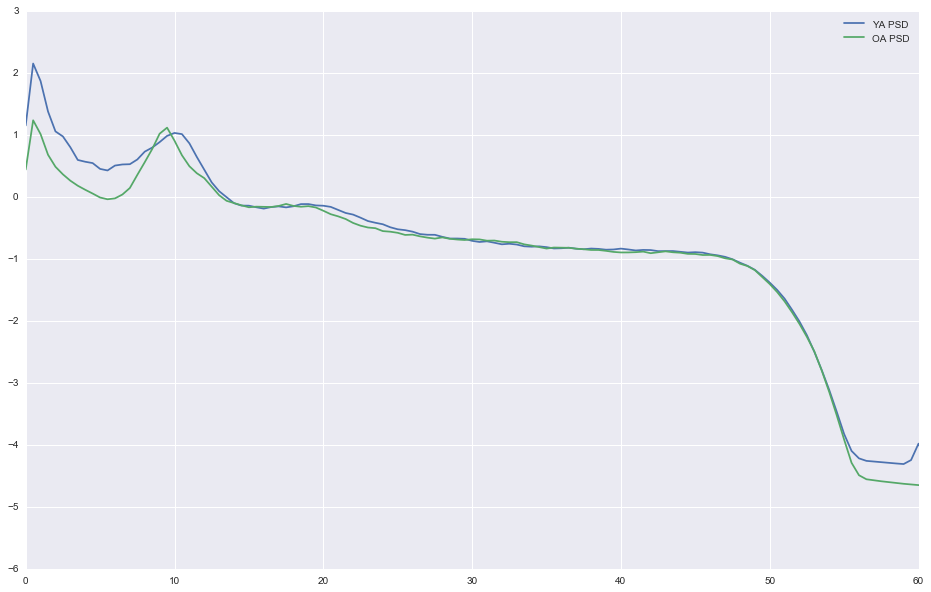

In [15]:
ya_psd = np.mean([subjya[i]['eyesC_psd'] for i in range(subjya['nbsubj']) if subjya[i]['age'] <= 35], axis=0)
oa_psd = np.mean([subjoa[i]['eyesC_psd'] for i in range(subjya['nbsubj']) if subjoa[i]['age'] >= 60 and subjoa[i]['age'] <= 70], axis=0)
plt.plot(subjoa['f'], np.log10(ya_psd), label='YA PSD')
plt.plot(subjoa['f'], np.log10(oa_psd), label='OA PSD')
plt.xlim([0, 60]); plt.legend()

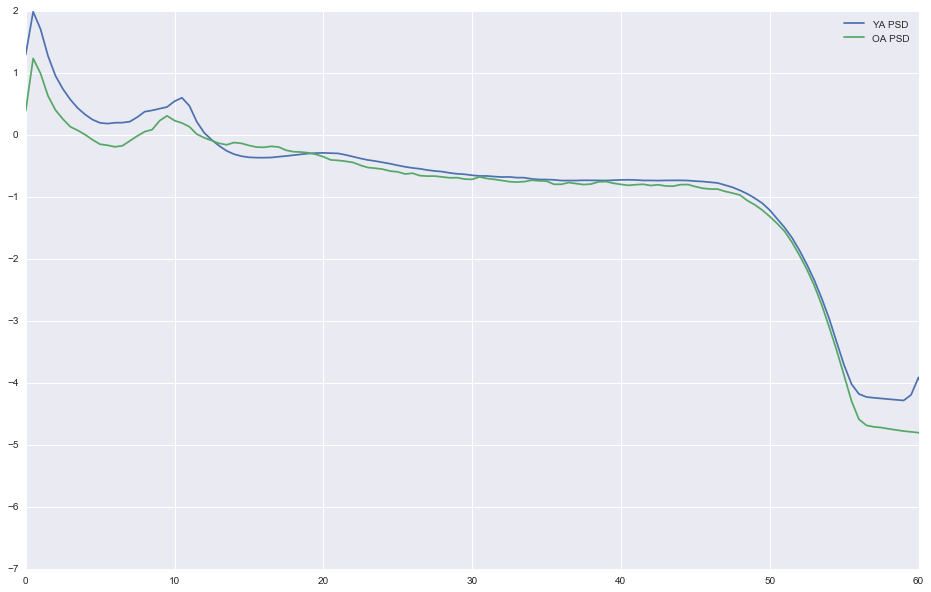

In [16]:
ya_psd = np.mean([subjya[i]['eyesO_psd'] for i in range(subjya['nbsubj']) if subjya[i]['age'] <= 35], axis=0)
oa_psd = np.mean([subjoa[i]['eyesO_psd'] for i in range(subjya['nbsubj']) if subjoa[i]['age'] >= 60 and subjoa[i]['age'] <= 70], axis=0)
plt.plot(subjoa['f'], np.log10(ya_psd), label='YA PSD')
plt.plot(subjoa['f'], np.log10(oa_psd), label='OA PSD')
plt.xlim([0, 60]); plt.legend()

## Occipital PSDs - note that occipital channel # is `57`

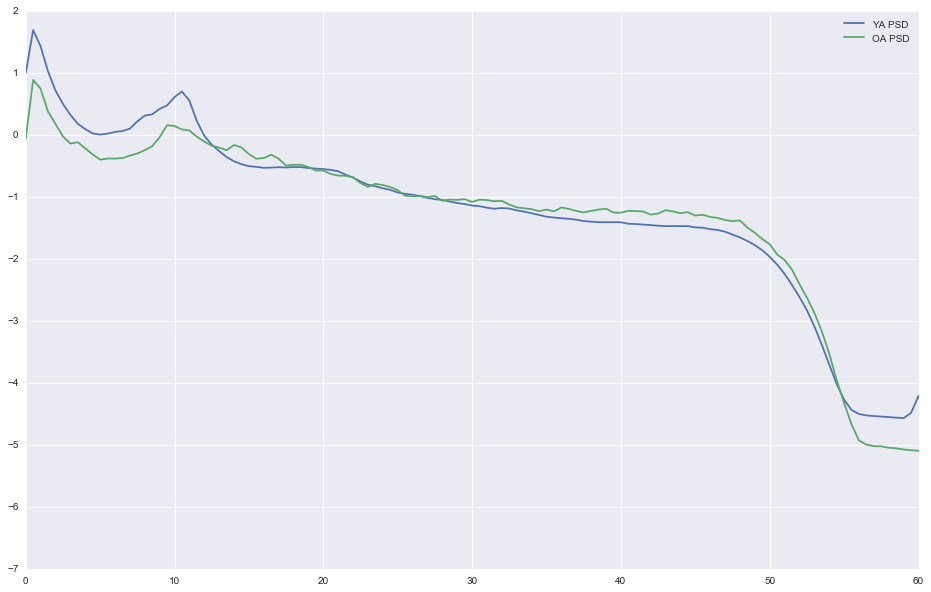

In [30]:
ya_psd = np.mean([subjya[i][57]['eyesO_psd'] for i in range(subjya['nbsubj']) if subjya[i]['age'] <= 35], axis=0)
oa_psd = np.mean([subjoa[i][57]['eyesO_psd'] for i in range(subjoa['nbsubj']) if subjoa[i]['age'] >= 60 and subjoa[i]['age'] <= 70], axis=0)
plt.plot(subjoa['f'], np.log10(ya_psd), label='YA PSD')
plt.plot(subjoa['f'], np.log10(oa_psd), label='OA PSD')
plt.xlim([0, 60]); plt.legend()

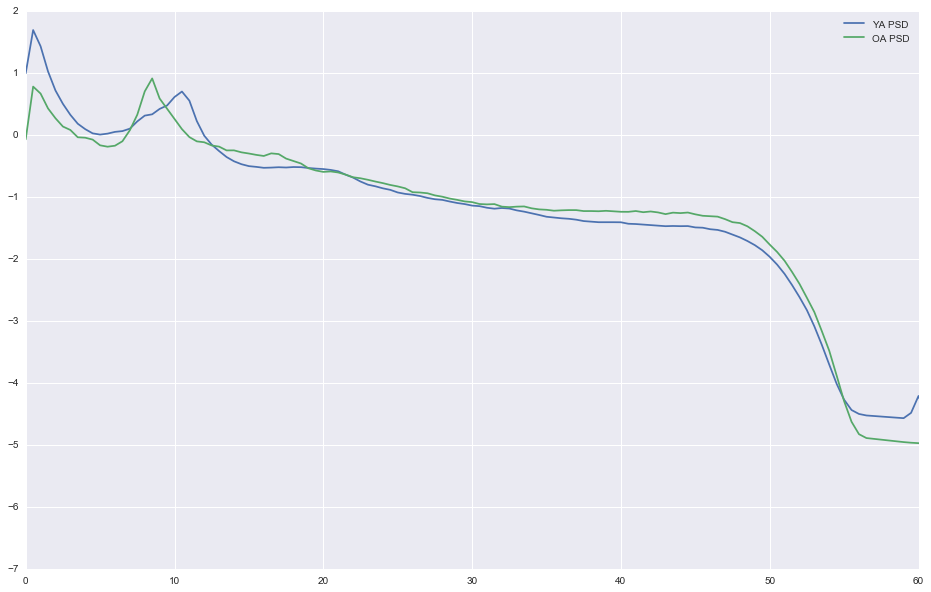

In [34]:
ya_psd = np.mean([subjya[i][57]['eyesO_psd'] for i in range(subjya['nbsubj']) if subjya[i]['age'] <= 35], axis=0)
oa_psd = np.mean([subjoa[i][57]['eyesO_psd'] for i in range(subjoa['nbsubj']) if subjoa[i]['class'] in older_adults], axis=0)
plt.plot(subjoa['f'], np.log10(ya_psd), label='YA PSD')
plt.plot(subjoa['f'], np.log10(oa_psd), label='OA PSD')
plt.xlim([0, 60]); plt.legend()